In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Wczytywanie i inspekcja danych danych

In [70]:
data = pd.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')

In [71]:
pd.set_option('display.max_columns', 100)
data.describe()

,CaseID,CASEID_NEW,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,duration,Q16,w6_q9,w6_q16,w6_q17,w6_q21a_year,w6_q21b_year,w6_q21b_month_flag,w6_q21c_year,w6_q21c_month_flag,w6_q21d_year,w6_q21e_year,w6_q21f_year,w6_outness_timing_all,w6_q24_length,w6_q26,w6_number_people_met,relate_duration_at_w6_years,w6_number_people_met_app,weight_combo_v2,female,year_fraction_met,year_fraction_relstart,age_when_met,time_from_met_to_rel,year_fraction_first_cohab,time_from_rel_to_cohab,hcm2017_q24_length,hcm2017q24_summary_all_codes,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
count,3510.000000,3.510000e+03,2994.000000,2994.000000,551.000000,3110.000000,3110.000000,3510.000000,3510.000000,3510.000000,2836.000000,3374.000000,3367.000000,3385.000000,3341.000000,3276.000000,3301.000000,2630.000000,80.0,2169.000000,410.000000,96.00000,476.000000,3394.000000,1799.000000,3359.000000,2765.000000,323.000000,3510.000000,3510.000000,3341.000000,3276.000000,3341.000000,3263.000000,2630.000000,2578.000000,3394.000000,3295.000000,3323.000000,3378.000000,3383.000000,3510.000000
mean,2121.318803,2.181073e+06,0.999999,78337.460938,1.000003,1.000001,78337.601562,1.000000,69410.132812,267.449858,3.495416,48.777119,3.463914,1.014771,1994.228973,1995.875153,0.039079,1994.570722,1.0,1992.834025,2008.048780,2007.00000,22.241597,182.854446,1.758199,0.448794,21.553467,1.752322,1.000000,0.502564,1994.719604,1996.380859,26.651003,1.597072,1995.073242,1.900667,182.912491,1.978756,12.138730,12.279752,14.033255,13.945868
std,1241.582562,6.401295e+05,0.285004,22326.515625,0.908374,0.289889,22709.197266,0.437515,30367.960938,1406.882283,5.095177,17.119645,5.109420,0.801753,17.108283,16.741519,0.193812,16.034225,0.0,16.470289,9.757077,9.97787,9.433113,236.993301,0.436015,2.849547,16.650276,5.072207,0.412794,0.500065,17.106398,16.735863,11.831717,4.361366,16.026445,2.727197,237.105286,1.118986,3.309426,3.229575,2.544954,2.546054
min,2.000000,5.300100e+04,0.264700,20736.000000,0.190300,0.263200,20618.000000,0.058970,4093.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,1939.000000,1942.000000,0.000000,1944.000000,1.0,1944.000000,1975.000000,1973.00000,0.000000,0.000000,-1.000000,0.000000,-0.333333,0.000000,0.082981,0.000000,1939.208374,1942.375000,0.000000,0.000000,1944.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1040.250000,1.825512e+06,0.808000,63297.000000,0.519650,0.805000,63062.000000,0.818612,56819.750000,8.000000,0.000000,34.000000,0.000000,1.000000,1981.000000,1983.000000,0.000000,1983.000000,1.0,1980.000000,2002.000000,2004.00000,17.000000,54.000000,2.000000,0.000000,7.250000,0.000000,0.809683,0.000000,1981.708374,1983.791626,18.000000,0.000000,1983.208374,0.333374,54.000000,1.000000,12.000000,12.000000,12.000000,12.000000
50%,2118.500000,2.282692e+06,0.943900,73943.000000,0.713300,0.946750,74166.000000,1.012706,70292.000000,11.000000,2.000000,50.000000,2.000000,1.000000,1998.000000,2000.000000,0.000000,1997.000000,1.0,1995.000000,2012.000000,2010.00000,20.000000,124.000000,2.000000,0.000000,18.083334,0.000000,0.997158,1.000000,1998.208374,2000.041626,23.000000,0.166748,1997.416748,1.000000,124.000000,2.000000,12.000000,12.000000,13.000000,13.000000
75%,3189.750000,2.759544e+06,1.142650,89512.250000,1.134700,1.145200,89712.250000,1.245077,86421.000000,19.000000,5.000000,62.000000,5.000000,1.000000,2009.000000,2010.000000,0.000000,2009.000000,1.0,2008.000000,2016.000000,2014.00000,26.000000,222.750000,2.000000,0.000000,34.166668,1.000000,1.223694,1.000000,2009.458374,2010.958374,32.000000,1.083252,2009.291626,2.416626,222.750000,3.000000,13.000000,14.000000,16.000000,16.000000
max,4311.000000,2.972135e+06,2.671000,209239.000000,7.797400,2.751100,215514.000000,3.110826,215923.000000,22135.000000,50.000000,95.000000,50.000000,4.000000,2017.000000,2017.000000,1.000000,2017.000000,1.0,2017.000000,2017.000000,2017.00000,70.000000,3855.000000,2.000000,75.000000,75.166664

Chcemy wybrać cechy, które nie mają dużo NaN (w tym przypadku mniej niż 10% wszystkich danych):

### Wybrane cechy

#### Ilościowe:
* w6_q21c_year - w którym roku po raz pierwszy zamieszkali ze sobą
* year_fraction_met - rok poznania z uwzględnieniem miesiąca jako ułamka

### Jakościowe:
* hcm2017q24_btwn_I_neighbor - czy są sąsiadami
* w6_otherdate_all - czy w zeszłym roku poznał(a) kogoś poza partnerem

In [72]:
cat_features = ['hcm2017q24_btwn_I_neighbor', 'w6_otherdate_all']
cont_features = ['w6_q21c_year', 'year_fraction_met']
label = 'S1'

## Transformowanie danych

Podstawowe transformowanie danych:
* zamiana wektora y na wektor 0/1 (0 - małżeństwo, 1 - brak małżeństwa)
* zamiana cech kategorycznych na one hot encoding
* usunięcie niedozwolonych przez XGBooost znaków z nazw cech

Sprawdzamy też, czy po usunięciu NaN nie zostało za mało danych.

In [73]:
data = data[cat_features+cont_features+[label]].dropna()
print("Data left: " + str(len(data)))
X = data[cat_features+cont_features].copy()
y = data[label].cat.codes

Data left: 2566


In [74]:
# Convert continuous features to numerics
for cont_feature in cont_features:
    X[cont_feature] = pd.to_numeric(X[cont_feature])
# One hot encoding
X = pd.get_dummies(X)
# Delete unwanted characters
for character in ['[', ']', '<']:
    X.columns = X.columns.str.replace(character, '')

## Trening

Do treningu używam klasyfikatora XGB z domyślnymi parametrami.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [76]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [77]:
print("Accuracy: "+str(accuracy_score(model.predict(X_test), y_test)))

Accuracy: 0.8099688473520249


## Rysowanie Ceteris Paribus

In [78]:
def get_values_and_probabilities(model, data, sample, feature_name, points=100):
    # Generate data
    values = np.linspace(data[feature_name].min(), data[feature_name].max(), points)
    samples = pd.concat([sample]*points)
    samples[feature_name] = values
    # Compute probabilities with model
    probs = model.predict_proba(samples)[:, 0]
    return values, probs

def draw_plot(values, probs, feature_name, sample):
    plt.plot(values, probs)
    sample_proba = model.predict_proba(sample)[:, 0]
    plt.scatter([float(sample[feature_name])], sample_proba)
    plt.xlabel(feature_name)
    plt.ylabel("Probability of being married")

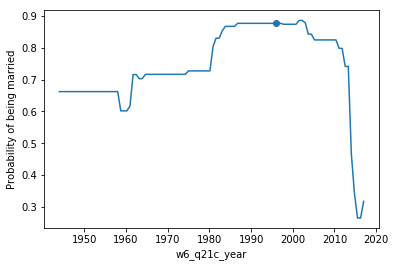

In [79]:
values, probs = get_values_and_probabilities(model, X, X.loc[[1]], cont_features[0])
draw_plot(values, probs, cont_features[0], X.loc[[1]])

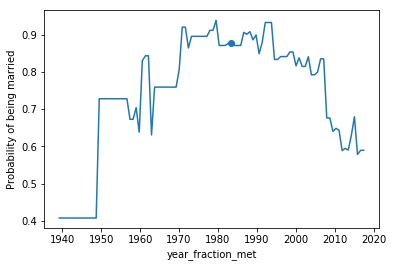

In [80]:
values, probs = get_values_and_probabilities(model, X, X.loc[[1]], cont_features[1])
draw_plot(values, probs, cont_features[1], X.loc[[1]])

## Wykresy MP

In [180]:
N_POINTS = 100
def draw_mp_plot(model, X, feature_name, dist, n_points=N_POINTS):
    xs = np.linspace(X[feature_name].min(), X[feature_name].max(), n_points)
    ys = []
    
    for x in xs:
        # get neighbours
        neighbours = X[abs(X[feature_name]-x) < dist].copy()
        neighbours[feature_name] = x
        
        if not neighbours.empty:
            ys.append(model.predict_proba(neighbours)[:, 0].mean())
        else:
            ys.append(ys[-1])
    plt.title("MP plot")
    plt.xlabel(feature_name)
    plt.ylabel("Probability of getting married")
    plt.plot(xs, ys)

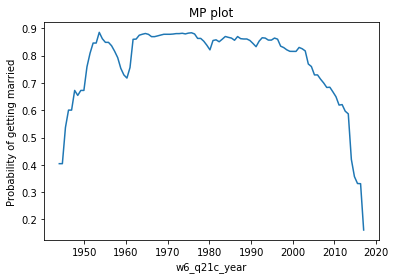

In [181]:
draw_mp_plot(model, X.copy(), cont_features[0], 5.0)

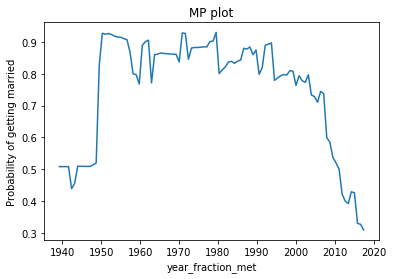

In [174]:
draw_mp_plot(model, X.copy(), cont_features[1], 5.0)

## Wykresy PDP

In [175]:
def draw_pd_plot(model, X, feature_name):
    xs = np.linspace(X[feature_name].min(), X[feature_name].max(), N_POINTS)
    ys = []
    for x in xs:
        X[feature_name] = x
        ys.append(model.predict_proba(X)[:, 0].mean())
        
    plt.title("PDP plot")
    plt.xlabel(feature_name)
    plt.ylabel("Probability of getting married")
    plt.plot(xs, ys)

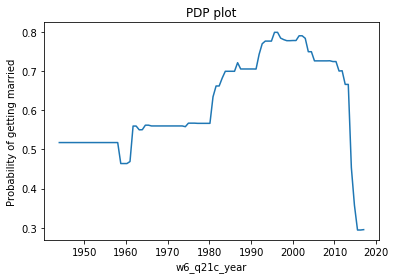

In [176]:
draw_pd_plot(model, X.copy(), cont_features[0])

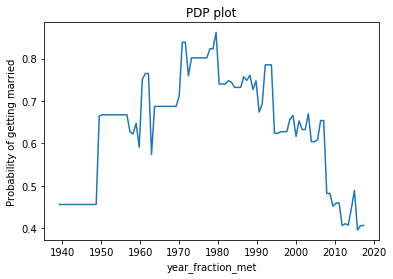

In [177]:
draw_pd_plot(model, X.copy(), cont_features[1])

## Opis
Wybrane cechy są silnie skorelowane (rok poznania i rok wzajemnego zamieszkania), przez co niektóre kombinacje przy rysowaniu CP nie miały sensu (np. zamieszkanie przed poznaniem). <br />
Dlatego też widać pewne róznice pomiędzy wykresami PDP a wykresami MP. Wykresy MP są bardziej gładkie i pokazują mniejszy wpływ danych cech na odpowiedź modelu. <br />
Gwałtowny spadek na końcu wykresu związany jest najprawdopodobniej z małą liczbą przykładów z tymi wartościami.